This example shows a Total Lagrangian formulation based on 8-node quadrilateral elements. A point force in vertical direction is applied to the right tip of the beam, createing bending-type large displacements.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import meshio
import sys
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import spsolve

class FEA:
    class Mesh:
        def __init__(self, nodes, elements):
            self.nodes = nodes
            self.elements = elements
            self.numN = nodes.shape[0]
            self.numE = elements.shape[0]
            self.ndofs_per_dimension = self.numN
            self.total_dofs = 2 * self.ndofs_per_dimension

    class DirichletBC:
        def __init__(self, mesh, constrained_dofs):
            self.constrained_dofs = constrained_dofs
            self.free_dofs = np.setdiff1d(np.arange(0, mesh.total_dofs), constrained_dofs)
    
    class NeumannBC:
        def pointLoad(self, value_x, value_y, node_index, mesh):
            load_vector = np.zeros((mesh.total_dofs, 1))
            load_vector[node_index] = value_x
            load_vector[node_index + mesh.ndofs_per_dimension] = value_y
            return load_vector

    def LoadMesh(self, filename, element_type):
        mesh = meshio.read(filename)
        nodes = mesh.points
        elements = mesh.cells_dict[element_type]
        return self.Mesh(nodes, elements)
    
    def GeometricNonlinearTL(self, mesh, material, discretization, DirichletBC, ExternalForce, steps=100):
        U = np.zeros((mesh.total_dofs,1))
        numN_element = mesh.elements.shape[1]
        for outer_iter in np.arange(1,steps+1):
            R = ExternalForce * outer_iter / steps
            for inner_iter in np.arange(1,101):
                row_idx, col_idx, data_val_K, data_val_M = [], [], [], []
                F = np.zeros((mesh.total_dofs, 1))
                for elem_node_indices in mesh.elements:
                    phi = np.array(elem_node_indices)
                    
                    Ke = np.zeros((2 * numN_element, 2 * numN_element))
                    Fe = np.zeros((2 * numN_element, 1))

                    # ----- Stiffness Matrix Integration -----
                    for j, r in enumerate(discretization.GQ_K_x):
                        for k, s in enumerate(discretization.GQ_K_x):

                            J = discretization.dhdR(r, s) @ mesh.nodes[elem_node_indices, :2]
                            HrHs = discretization.dhdR(r, s)    # Shape: (2, 2 * numN_element)
                            HxHy = np.linalg.solve(J, HrHs)     # Shape: (2, 2 * numN_element)
                            Hx, Hy = HxHy[0], HxHy[1]           # Extract rows
                            Hx = Hx.reshape(1, -1)
                            Hy = Hy.reshape(1, -1)

                            # G-L strain and 2nd Piola-Kirchhoff stress
                            eps11 = Hx @ U[phi] + 0.5 * (Hx @ U[phi])**2 + 0.5 * (Hx @ U[phi + mesh.ndofs_per_dimension])**2
                            eps22 = Hy @ U[phi + mesh.ndofs_per_dimension] + 0.5 * (Hy @ U[phi])**2 + 0.5 * (Hy @ U[phi + mesh.ndofs_per_dimension])**2
                            eps12 = 0.5 * ( Hy @ U[phi] 
                                        + Hx @ U[phi + mesh.ndofs_per_dimension] 
                                        + Hx @ U[phi] * Hy @ U[phi] 
                                        + Hx @ U[phi + mesh.ndofs_per_dimension] * Hy @ U[phi + mesh.ndofs_per_dimension])
                            S = material.C @ np.concatenate([eps11, eps22, 2*eps12])

                            # K_linear
                            B_L = np.block([
                                [Hx + Hx @ U[phi] * Hx, Hx @ U[phi + mesh.ndofs_per_dimension] * Hx],
                                [Hy @ U[phi] * Hy, Hy + Hy @ U[phi + mesh.ndofs_per_dimension] * Hy],
                                [Hy + Hy @ U[phi] * Hx + Hx @ U[phi] * Hy, Hx + Hy @ U[phi + mesh.ndofs_per_dimension] * Hx + Hx @ U[phi + mesh.ndofs_per_dimension] * Hy]
                            ])
                            K_L = B_L.T @ material.C @ B_L

                            # K_nonlinear
                            K_NL11 = np.block([
                                [Hx.T * S[0] @ Hx, np.zeros((numN_element, numN_element))],
                                [np.zeros((numN_element, numN_element)), Hx.T * S[0] @ Hx]
                                ])
                            K_NL22 = np.block([
                                [Hy.T * S[1] @ Hy, np.zeros((numN_element, numN_element))],
                                [np.zeros((numN_element, numN_element)), Hy.T * S[1] @ Hy]
                                ])
                            K_NL12 = np.block([
                                [Hy.T * S[2] @ Hx + Hx.T * S[2] @ Hy, np.zeros((numN_element, numN_element))],
                                [np.zeros((numN_element, numN_element)), Hy.T * S[2] @ Hx + Hx.T * S[2] @ Hy]
                            ])
                            K_NL = K_NL11 + K_NL22 + K_NL12

                            Ke += (K_L + K_NL) * np.linalg.det(J) * discretization.GQ_K_w[j] * discretization.GQ_K_w[k]
                            Fe += B_L.T @ S * np.linalg.det(J) * discretization.GQ_K_w[j] * discretization.GQ_K_w[k]

                    # ----- Collect Stiffness Matrices -----
                    for i in range(2 * numN_element):
                        for j in range(2 * numN_element):
                            row = phi[i] if i < numN_element else phi[i - numN_element] + mesh.ndofs_per_dimension
                            col = phi[j] if j < numN_element else phi[j - numN_element] + mesh.ndofs_per_dimension
                            row_idx.append(row)
                            col_idx.append(col)
                            data_val_K.append(Ke[i, j])

                    F[np.concatenate([phi, phi + mesh.ndofs_per_dimension])] += Fe
                
                # ----- Assemble Global Stiffness Matrix -----
                K = coo_matrix((data_val_K, (row_idx, col_idx)), shape=(mesh.total_dofs, mesh.total_dofs)).tocsr()
                K_ff = K[DirichletBC.free_dofs[:, None], DirichletBC.free_dofs]  # shape: (n_free, n_free)
                # Residual vector for free DOFs
                residual = R[DirichletBC.free_dofs] - F[DirichletBC.free_dofs]   # shape: (n_free,)
                # Solve for displacement increment
                del_U = spsolve(K_ff, residual).reshape(-1, 1)
                U[DirichletBC.free_dofs] += del_U
                # Save condition number for each inner iteration
                if outer_iter == 1 and inner_iter == 1:
                    cond_Kff_arr = []
                cond_Kff = np.linalg.cond(K_ff.toarray())
                cond_Kff_arr.append(cond_Kff)
                #print(f"Condition number of K_ff: {cond_Kff:.3e}")
                if np.linalg.norm(residual)/np.linalg.norm(R) < 1e-3:
                    print(f"Converged at the outer iteration {outer_iter:>3} with {inner_iter:>3} inner iterations.")
                    U_history = np.concatenate([U_history, U], axis=1) if outer_iter > 1 else U
                    break
                elif inner_iter == 100:
                    print(f"Error: Did not converge within the maximum number of inner iterations 100 for the outer iteration {outer_iter}.")
                    sys.exit(1)
                    
        return U_history
    
    class LinearElasticMaterial2D:
        def __init__(self, E=210e9, nu=0.3, type='plane_stress'):
            self.E = E
            self.nu = nu
            self.C = self.planeStressMatrix() if type == 'plane_stress' else self.planeStrainMatrix()
        def planeStressMatrix(self):
            E, nu = self.E, self.nu
            factor = E / (1 - nu**2)
            return factor * np.array([[1, nu, 0], [nu, 1, 0], [0, 0, (1 - nu) / 2]])
        def planeStrainMatrix(self):
            E, nu = self.E, self.nu
            factor = E * (1 - nu) / ((1 + nu) * (1 - 2 * nu))
            return factor * np.array([[1, nu / (1 - nu), 0], [nu / (1 - nu), 1, 0], [0, 0, (1 - 2 * nu) / (2 * (1 - nu))]])
        
    # ====================== Element Class ======================
    class Element8node2D:
        
        GQ_K_x, GQ_K_w = np.polynomial.legendre.leggauss(3)

        def dhdR(self, r, s):
            # dN/dr
            dhdr = np.array([
                (1 - s) * (2*r + s) / 4,          # N1,r
                (1 - s) * (2*r - s) / 4,          # N2,r
                (1 + s) * (2*r + s) / 4,          # N3,r
                (1 + s) * (2*r - s) / 4,          # N4,r
                -r * (1 - s),                     # N5,r
                (1 - s**2) / 2,                   # N6,r
                -r * (1 + s),                     # N7,r
                -(1 - s**2) / 2                   # N8,r
            ])

            # dN/ds
            dhds = np.array([
                (1 - r) * (r + 2*s) / 4,          # N1,s
                (1 + r) * (2*s - r) / 4,          # N2,s
                (1 + r) * (r + 2*s) / 4,          # N3,s
                (1 - r) * (2*s - r) / 4,          # N4,s
                -(1 - r**2) / 2,                  # N5,s
                -s * (1 + r),                     # N6,s
                (1 - r**2) / 2,                   # N7,s
                -s * (1 - r)                      # N8,s
            ])

            return np.array([dhdr, dhds])

        def h(self,r, s):
            return np.array([
                -(1 - s) * (1 - r) * (1 + r + s) / 4,
                -(1 - s) * (1 + r) * (1 - r + s) / 4,
                -(1 + s) * (1 + r) * (1 - r - s) / 4,
                -(1 + s) * (1 - r) * (1 + r - s) / 4,
                (1 - s) * (1 - r) * (1 + r) / 2,
                (1 + r) * (1 - s) * (1 + s) / 2,
                (1 + s) * (1 - r) * (1 + r) / 2,
                (1 - r) * (1 - s) * (1 + s) / 2
            ])

# ====================== Problem Setup ======================
analysis = FEA()

mesh = analysis.LoadMesh("SlenderBeamBendingExample.msh", "quad8")
material = analysis.LinearElasticMaterial2D(E=8, nu=0.3)
discretization = analysis.Element8node2D()

# ====================== Dirichlet Boundary Conditions ======================
BC_fix_xdir = np.where(mesh.nodes[:, 1] == 0)[0]
BC_fix_ydir = BC_fix_xdir + mesh.ndofs_per_dimension
DirichletBC = analysis.DirichletBC(mesh, np.unique(np.concatenate([BC_fix_xdir, BC_fix_ydir])))

# ====================== Neumann Boundary Conditions ======================
# Find the node with maximum x and maximum y (tip corner)
index_tip = np.where((mesh.nodes[:, 0] == mesh.nodes[:, 0].max()) & (mesh.nodes[:, 1] == mesh.nodes[:, 1].max()))[0][0]
NeumannBC = analysis.NeumannBC().pointLoad(0, -2e-3, index_tip, mesh)

# ======================= TL Solver Setup =======================
U_history = analysis.GeometricNonlinearTL(mesh, material, discretization, DirichletBC, NeumannBC, steps=100)




Converged at the outer iteration   1 with   5 inner iterations.
Converged at the outer iteration   2 with   5 inner iterations.
Converged at the outer iteration   3 with   5 inner iterations.
Converged at the outer iteration   4 with   5 inner iterations.
Converged at the outer iteration   5 with   5 inner iterations.
Converged at the outer iteration   6 with   5 inner iterations.
Converged at the outer iteration   7 with   7 inner iterations.
Converged at the outer iteration   8 with  12 inner iterations.
Converged at the outer iteration   9 with  13 inner iterations.
Converged at the outer iteration  10 with  15 inner iterations.
Converged at the outer iteration  11 with  10 inner iterations.
Converged at the outer iteration  12 with   8 inner iterations.
Converged at the outer iteration  13 with   8 inner iterations.
Converged at the outer iteration  14 with   8 inner iterations.
Converged at the outer iteration  15 with   8 inner iterations.
Converged at the outer iteration  16 wi

: 

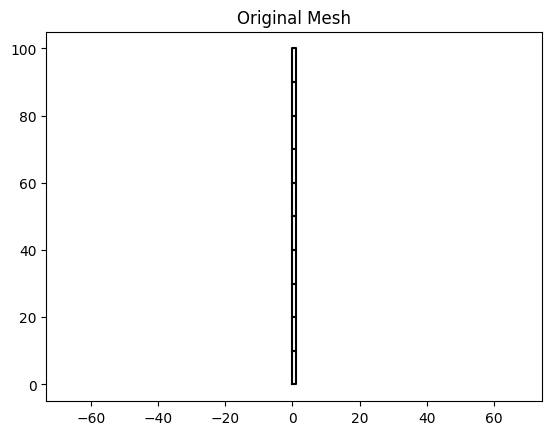

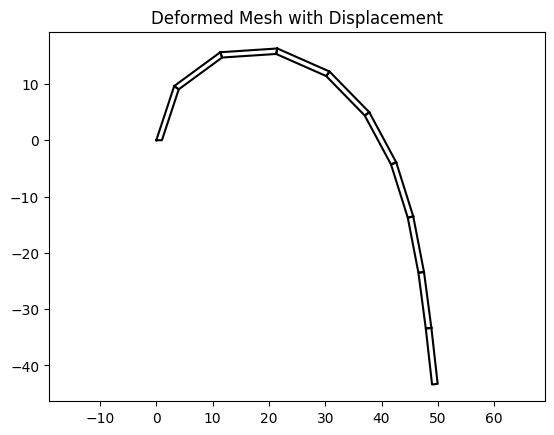

In [24]:
def drawmesh(nodes, elements, title=''):
    plt.figure()
    for elem in elements:
        pts = np.append(elem[:4], elem[0])  # Close the loop
        plt.plot(nodes[pts, 0], nodes[pts, 1], 'k-')
    plt.title(title)
    plt.axis('equal')
    plt.show()

# ====================== Visualization ======================          
drawmesh(mesh.nodes, mesh.elements, title='Original Mesh')
drawmesh(mesh.nodes[:,:2] + U_history[:,-1].reshape(-1, 2, order='F'), mesh.elements, title='Deformed Mesh with Displacement')